<h1>Example validation script</h1>
<p>In this notebook we walk you through the steps of validating your point predictions and pdfs. We will use the same codes that will be used in the final validation stage. To make this script realistic, with realistic run-timess, we have around 10,000 galaxies in our testing files.</p>
<p>First, ensure that your repo is up to date, by running this command</p>
<code>cd /path/to/photoz-wg/</code>

Followed by 

<code>git pull</code>

<h3>Unit tests</h3>
<p>You are welcome to enter into the validation/tests/ directory and run the unit tests using, e.g.,

<code>%>nosetests </code>

<p>If you would like to expand the unit tests, please do so! and push your changes to a branch. The more tests we have, the more we can belive our codes!</p>


<h3>The validation script</h3>
<p>The validation script is found in the validation directory. You may ignore this notebook, and call the validation script directly from the directory (or anywhere if you add the directory to your path variable). This will instantly check that your file is well formed, and then perform all the standard tests, and output the scores.</p>

usage like


<code>%>photoz_metrics.py data/PointPredictions1.fits</code>


or to do many pdfs predictions at a time

<code>%>photoz_metrics.py data/pdfPredictions*.hdf5</code>


or a mix of the two, many point prediction files, and many pdf files

<code>%>photoz_metrics.py data/pdfPredictions\*.hdf5 data/PointPredictions\*.fits</code>



or you can make more fine tuned validations using a configuration YaML file


<code>%>photoz_metrics.py yourValidationConfig.yaml </code>



<h4>help file</h4>
If your just call it like this:

<code>%>photoz_metrics.py</code> 



We will write a example YaML file "exampleValidation.yaml"  to the working directory.

<h3>The validation code</h3>
<p>Dependecies, pandas, astropy, pyYaml</p>

In [1]:
#some dependencies. We'll need YAML (pip install pyYaml)
%load_ext autoreload
%autoreload 2
import numpy as np
#doubled up for use later!
import numpy as numpy
import sys
import os
import yaml

#let's do some speed-testing
import time

#what is the path to DES photo-z wg bucket/validation?
#for Ben this is:
#modify this for your system
path_bh = '../validation/'

sys.path.append(path_bh)

import bh_photo_z_validation as pval

<h3>Load the point predictions files</h3>
<p>We assume that you already have the data in the correct format. This means it has the required point prediction redshift estimates, and Z_SPEC, and COADD_OBJECTS_ID and MAG_DETMODEL_I. We will now perform some "unit-tests" to ensure this.</p>

<p>In fact, in the code, we identify all the columnns that will be used in the specified tests, and check for their existence too!</p>

In [2]:
#change this to your fits file path
pointPredictionFitsPath = path_bh + 'tests/data/validPointPrediction.fits'

require_cols = ['Z_SPEC', 'COADD_OBJECTS_ID', 'MAG_DETMODEL_I', 'Z_MC']

#lets start the speed test counter!
t1 = time.time()

#let's check the file is valid, has the required columns, and load it in.
okay, dataFrame = pval.valid_file(pointPredictionFitsPath, require_cols)

#if it's not okay, we tell you why in the error message (now stored in dataFrame)
if okay is False:
    print "the file is not in the correct format"
    print "erorr message: " + dataFrame

print "data loaded in %0.4f secs for %0.1d galaxies" % (time.time() - t1, len(dataFrame))
print dataFrame[0:2]
print "number of objects in our test sample", len(dataFrame)

data loaded in 0.0397 secs for 10000 galaxies
COADD_OBJECTS_ID MAG_DETMODEL_I ...     Z_SPEC           Z_MC     
---------------- -------------- ... -------------- ---------------
               0  24.3865259087 ...  1.00535707155 0.0311218229133
               1  20.3067578704 ... 0.991885492609  0.648961886639
number of objects in our test sample 10000


<h3>Define the tests</h3>
<p>We next will build a test. We write each test as a really lovely YaML file. YaML is desgined to be easy for humans to read. You'll understand how easy each test becomes, in a few seconds. </p>

<p>Each test determines which metrics (such as $\sigma_{68}$ or the K-S test) will be measured, and optionally if we want to measure the metric by binning the data along one of the columns, e.g. if we want to bin along MAG_DETMODEL_I. We can also decide to set an allowed "tolerance", this informs us if the tests passed with the required precision</p>

<p>You don't need to write any tests if you don't want to. The standard ones are included already when you run the script from the command line. Below I shown an exmaple of what a test looks like. You can include as many tests, from as many sources as you like. Each test it it's own yaml file.</p>

<p>The base tests can be found here </p>

<code>%>ls photoz-wg/validation/testConfig/*.yaml</code>

And looks like this: [The comments '#' are also included in the file, for easy reading!]

===== begin YaML file =======

#First let us give this test a name, to differeniat it from other tests

test_name: example_test1

#paths to file locations. will assume '.fits' as point predictions '.hdf5' as pdf predictions, add more files to list to compare multiple files


filePaths: ['tests/data/validPointPrediction.fits', 'tests/data/validHDF.hdf5']

#Which metrics and tolerance should we measure either a list of metrics, such as and or a precomputed collection of group metrics and tolerances set blank, or delete this line to not use these preconfigured metrics/bins/tolerances

standardPredictions: [/testConfig/photoz.yaml, /testConfig/weak_lensing.yaml]

#what will the path/ and or/base file name of the results be called?

resultsFilePrefix: myResultsOutput

#And or / additionally choose your own metrics, as list
#remove these if not required
#these are the point prediction tests

point:
    
    #which photo-z predictions do we want to test
    predictions: [MODE_Z, MEAN_Z, Z_MC]
    
    #what is the true redshift that we will compare with?
    truths: Z_SPEC
    
    #should we calculated weighted metrics where available?
    weights: WEIGHTS

    #what metrics do we want to measure. "numpy.std" is the standard deviation from numpy
    
    # and "bh_photo_z_validation.sigma_68" is the sigma_68 metric found in the bh_photo_z_validation.py file
    
    metrics: [numpy.std, numpy.median, bh_photo_z_validation.sigma_68, bh_photo_z_validation.outlier_fraction]
    
    #do we want to assign an accetable tolerance to each of these tests?
    tolerance: [0.4, 0.001, 0.02, 5]
    
    #Finally do we want to also measure the metrics in some "bins".
    #we define the column_name: 'string of bins / string of function that makes bins'
    bins: [MAG_DETMODEL_I: '[10, 15, 20, 25, 30]', MODE_Z: 'numpy.linspace(0, 2, 20)']

    #Should we calculate errors on each metric? if yes state how
    #you can include as many different error functions as you like.
    error_function: [bh_photo_z_validation.bootstrap_mean_error]

#these are the pdf tests

pdf: 
    #we can examine individual redshift pdfs against a truth value. Remove this part if you don't want this
    individual:
        truths: Z_SPEC
        
        #one statistic is calcualted in bh_photo_z_validation.py eval_pdf_point(), add your own at will.
        metrics: [bh_photo_z_validation.eval_pdf_point]
        bins: [MAG_DETMODEL_I: '[ 17.5, 19, 22, 25]']
        tolerance: [0.7, 20]
        #shall we use weights when calculating metrics, if so specify here.
        weights: WEIGHTS

    #or shall we compare against stacked pdfs
    stacks:
        truths: Z_SPEC
        #we convert truths to a distribution by choosing these bins
        truth_bins: [Z_SPEC: 'numpy.linspace(0, 2, 4)']

        #which additional bins shall we use to measure metrics in?
        metric_bins: [MAG_DETMODEL_I: '[ 17.5, 19, 22, 25]']
        
        #which pdf/ distribution comparison metrics should we measure 
        metrics: [bh_photo_z_validation.kstest, bh_photo_z_validation.npoisson, bh_photo_z_validation.log_loss]
        tolerance: [0.7, 20]
        #shall we use weights when calculating metrics, if so specify here.
        weights: WEIGHTS
===== end YaML file =======

You see that we have now defined a set of tests for both point predictions, and pdfs.


<h3>Loading the tests</h3>
<p>We load the tests like this!</p>

In [3]:
testYamlPath = path_bh + 'testConfig/photoz.yaml'
testConfig = yaml.load(open(testYamlPath, 'r'))

#check that the test is valid. This is die if it's not.
isTestValid = pval.valid_tests(testConfig)

#the YaML file is parsed nicely to a python dictionary!
print "This test is called: " + testConfig['test_name'] + '\n'
print testConfig
print "\n\nExample of extracting a statistic to measure\n"
print testConfig['point']['metrics'][1]
print "\nExample of which error we can assign to this metric\n"
print testConfig['point']['error_function'][0]

print "\nThis means look in bh_photo_z_validation.py to see this function. You can add your own error function too!"

This test is called: photoz-wg

{'pdf': {'individual': {'metrics': ['bh_photo_z_validation.Bordoloi_pdf_test'], 'metric_bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}], 'weights': 'WEIGHT', 'error_function': ['bh_photo_z_validation.bootstrap_mean_error_pdf_point'], 'tolerance': [0.7, 20], 'truths': 'Z_SPEC'}, 'stacks': {'metrics': ['bh_photo_z_validation.ks_test', 'bh_photo_z_validation.npoisson', 'bh_photo_z_validation.log_loss'], 'weights': 'WEIGHT', 'truth_bins': [{'Z_SPEC': 'numpy.arange(5)*0.33'}], 'tolerance': [0.7, 20], 'truths': 'Z_SPEC', 'bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}]}}, 'test_name': 'photoz-wg', 'point': {'metrics': ['numpy.std', 'numpy.median', 'bh_photo_z_validation.sigma_68', 'bh_photo_z_validation.outlier_fraction'], 'weights': 'WEIGHTS', 'error_function': ['bh_photo_z_validation.bootstrap_mean_error'], 'tolerance': [0.4, 0.001, 0.02, 5], 'truths': 'Z_SPEC', 'predictions': ['MODE_Z', 'Z_MC'], 'bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}, {'MO

<h3>YaML corrupt?</h3>
<p>If your YaML file doesn't work, copy and check it here: http://yaml-online-parser.appspot.com

<h3>Running a test for point predictions</h3>
<p>Now we can play some testing magic. One thing to note, is they Python is <b>friggin</b> awesome. Remember we wrote the metric like this: 'bh_photo_z_validation.sigma_68', well we can turn this into an executable using a function found in bh_photo_z_validation.py called get_function(). We'll see this in the below.</p>

In [4]:
pointTestConfig = testConfig['point']
for eachPointPrediction in pointTestConfig['predictions']:
    #let's calcalate the redshift scaled residuals Deltaz = (z - photz) / (1 + z)
    deltaz_1pz = pval.delta_z_1pz(dataFrame[pointTestConfig['truths']], dataFrame[eachPointPrediction])
    
    #are we adding weights to each galaxy prediction?
    weights = dataFrame[pointTestConfig['weights']]
    
    #now let's calculate the value of each chosen metric
    for i, eachMetric in enumerate(pointTestConfig['metrics']):
        
        #amazing metric string to function conversion. 
        #Add your own functions by putting them in bh_photo_z_validation.py
        metric_function = pval.get_function(eachMetric)
        metric_value =  metric_function(deltaz_1pz)
        
        t1 = time.time()
        #no add our generic error function, we'll need weights for this
        error_function = pval.get_function(pointTestConfig['error_function'][0])
        print "\n200 BootStrap errors calculated in  in %0.6f secs for %0.1d galaxies" % (time.time() - t1, len(dataFrame))
        
        error_value = error_function(deltaz_1pz, weights, metric_function)
        
        print " \n"
        print "using file: " + pointPredictionFitsPath 
        print "point prediction: " + eachPointPrediction 
        print "we measure the statistic: " + eachMetric.split('.')[-1] 
        print "and get the value: " + str(metric_value) + " [or error and mean from bootstrap]", error_value
        if metric_value < pointTestConfig['tolerance'][i]:
            print "This bettter than expected!"
        else:
            print "This is worse than expected!"

# All the results of these tests will be printed to the screen below


200 BootStrap errors calculated in  in 0.000012 secs for 10000 galaxies
 

using file: ../validation/tests/data/validPointPrediction.fits
point prediction: MODE_Z
we measure the statistic: std
and get the value: 0.255770026096 [or error and mean from bootstrap] {'sigma': 0.0013828728692445009, 'mean': 0.25471599768750891}
This bettter than expected!

200 BootStrap errors calculated in  in 0.000013 secs for 10000 galaxies
 

using file: ../validation/tests/data/validPointPrediction.fits
point prediction: MODE_Z
we measure the statistic: median
and get the value: 0.191660584106 [or error and mean from bootstrap] {'sigma': 0.0039549296798373212, 'mean': 0.1930734501471853}
This is worse than expected!

200 BootStrap errors calculated in  in 0.000011 secs for 10000 galaxies
 

using file: ../validation/tests/data/validPointPrediction.fits
point prediction: MODE_Z
we measure the statistic: sigma_68
and get the value: 0.280389329011 [or error and mean from bootstrap] {'sigma': 0.00207157327

<h2>pdf tests</h2>
<p>Now let's turn our attention to the pdf tests. Let's load them and look at them.</p>

In [5]:
pdfTestConfig = testConfig['pdf']
print pdfTestConfig

{'individual': {'metrics': ['bh_photo_z_validation.Bordoloi_pdf_test'], 'metric_bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}], 'weights': 'WEIGHT', 'error_function': ['bh_photo_z_validation.bootstrap_mean_error_pdf_point'], 'tolerance': [0.7, 20], 'truths': 'Z_SPEC'}, 'stacks': {'metrics': ['bh_photo_z_validation.ks_test', 'bh_photo_z_validation.npoisson', 'bh_photo_z_validation.log_loss'], 'weights': 'WEIGHT', 'truth_bins': [{'Z_SPEC': 'numpy.arange(5)*0.33'}], 'tolerance': [0.7, 20], 'truths': 'Z_SPEC', 'bins': [{'MAG_DETMODEL_I': '[ 17.5, 19, 22, 25]'}]}}


<h3>Load pdf data</h3>
<p>Lets load some data, and check that the data file is valid, and contains the columns we will be using.</p>

In [6]:
pdfPredictionFitsPath = path_bh + 'tests/data/validHDF.hdf5'

require_cols = ['Z_SPEC', 'COADD_OBJECTS_ID', 'MAG_DETMODEL_I']

t1 = time.time()      
okay, dataFrame = pval.valid_file(pdfPredictionFitsPath, require_cols)
print "\npdf file loaded in %0.4f secs for %0.1d galaxies" % (time.time() - t1, len(dataFrame))
  
if okay is False:
    print "the file is not in the correct format"
    print "erorr message: " + dataFrame
#print dataFrame[0:1], 'lenght', len(dataFrame)
print dataFrame.info()
dataFrame.head()


pdf file loaded in 0.1570 secs for 10000 galaxies
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 304 entries, COADD_OBJECTS_ID to MAG_DETMODEL_I
dtypes: float64(303), int64(1)
memory usage: 23.3 MB
None


,COADD_OBJECTS_ID,Z_SPEC,pdf_0.0,pdf_0.00666666666667,pdf_0.0133333333333,pdf_0.02,pdf_0.0266666666667,pdf_0.0333333333333,pdf_0.04,pdf_0.0466666666667,...,pdf_1.94666666667,pdf_1.95333333333,pdf_1.96,pdf_1.96666666667,pdf_1.97333333333,pdf_1.98,pdf_1.98666666667,pdf_1.99333333333,WEIGHT,MAG_DETMODEL_I
0,0,0.877001,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000,...,0,0,0,0,0,0,0,0,0.000066,23.638271
1,1,0.198939,0.0000,0.0015,0.0000,0.0000,0.003,0.0075,0.0075,0.006,...,0,0,0,0,0,0,0,0,0.000067,18.028284
2,2,0.486581,0.0015,0.0060,0.0015,0.0015,0.006,0.0075,0.0075,0.006,...,0,0,0,0,0,0,0,0,0.000068,23.735735
3,3,1.114063,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000,...,0,0,0,0,0,0,0,0,0.000067,19.771337
4,4,0.928459,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000,...,0,0,0,0,0,0,0,0,0.000067,26.751157


<h3>pdf array</h3>
Let's extract the pdfs as an N-darray of shape (ngals, nbins).

We also have access to the bin edges using the pdf_key valus<p>

In [7]:
zcols = [c for c in dataFrame.keys() if 'pdf_' in c]
print "pdf bin cols", zcols[0:3]
zbins = np.array([float(c.split('f_')[-1]) for c in zcols])
print "pdf bin centers", zbins[0:3]

pdf bin cols ['pdf_0.0', 'pdf_0.00666666666667', 'pdf_0.0133333333333']
pdf bin centers [ 0.          0.00666667  0.01333333]


In [8]:
pdfs = dataFrame[zcols].values

<h3>Applying some tests</h3>
Let's apply some test. First let's stack all pdfs and plot them against the Z_SPEC dist. (note, this is all random data, so don't expect a correlation!). We'll use tools found in bh_photo_z_validation.py to do all the heavy lifting

In [9]:
t1 = time.time()          
#stack all pdfs across all gals
stackedPdf = pval.stackpdfs(pdfs)

#normalise this stack
normStackedPdf = pval.normalisepdfs(stackedPdf, zbins)

#make df for Z_SPEC #numpy.histogram needs the final bin edge
dndz = np.histogram(dataFrame['Z_SPEC'], bins=np.append(zbins,2))[0]*1.0
z_pdf = pval.normalisepdfs(dndz, zbins)

print "\n All computations took %0.4f secs for %0.1d galaxies" % (time.time() - t1, len(pdfs))


 All computations took 0.0044 secs for 10000 galaxies


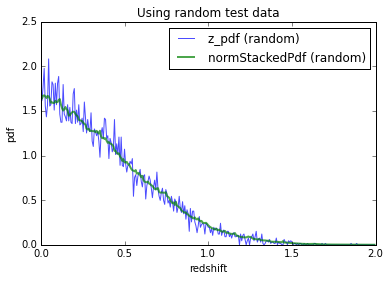

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(zbins, z_pdf, label='z_pdf (random)', linewidth=1, alpha=0.7)
plt.plot(zbins, normStackedPdf, label='normStackedPdf (random)', linewidth=2, alpha=0.7)
plt.title('Using random test data')
plt.xlabel('redshift')
plt.ylabel('pdf')
plt.legend()

<h3>Fake data</h3>
<p> Do note we are just using some meaningless, random, made up data.</p>
<p>Let's continue with the tutorial and perform some other comparisons on these (meaningless) distributions!</p>
<p>Let's find how much of each galaxy's pdf sits within some bin.<p>

In [11]:
t1 = time.time()
pdf_in_int = pval.integrate_dist_bin(pdfs,zbins, 0.1, 0.3)
print "\n All computations took %0.4f secs for %0.1d galaxies" % (time.time() - t1, len(pdfs))


 All computations took 0.0096 secs for 10000 galaxies


<p>Now, let's plot a few of those with lots of pdf in the bin</p>

(0, 0.5)

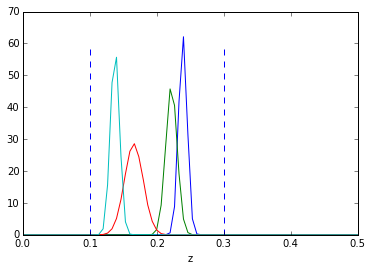

In [12]:
i = pdf_in_int > 0.95
for j in range(4):
    plt.plot(zbins, pdfs[i][j])
plt.plot([0.1,0.1], [0,60], '--b')
plt.plot([0.3,0.3], [0,60], '--b')
plt.xlabel('z')
plt.xlim(0,0.5)

and plot a few with only a little weight in the bin

(0.08, 0.35)

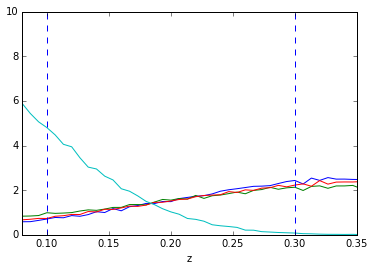

In [13]:
i = (pdf_in_int > 0.3) * (pdf_in_int < 0.31)
for j in range(4):
    plt.plot(zbins, pdfs[i][j])
plt.plot([0.1,0.1], [0,10], '--b')
plt.plot([0.3,0.3], [0,10], '--b')
plt.xlabel('z')
plt.xlim(0.08,0.35)

<h3>Bordoloi pdf test</h3>
<p>One test that we perform is the Bordoloi et al 2012 http://arxiv.org/pdf/1201.0995.pdf test. The idea is to make a cumulative pdf for each galaxy, and then calculate the y-axis value that corresponds to the x-axis value of the spectroscopic (or other) redshift.
<br>
This statistics, averaged over many galaxies, should have a flat distribution in y-axis values (between 0-1). To check how flat it is, we can us the gini criteria! [https://en.wikipedia.org/wiki/Gini_coefficient]
</p>


0.177014
this is quite flat! let's check it out

 All computations (including plots) took 0.5595 secs for 10000 galaxies


/Users/hoyleb/Documents/python/modules/photoz-wg/validation/bh_photo_z_validation.py:404: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  points[points > x[-1]] = x[-1]
/Users/hoyleb/Documents/python/modules/photoz-wg/validation/bh_photo_z_validation.py:405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  points[points < x[0]] = x[0]


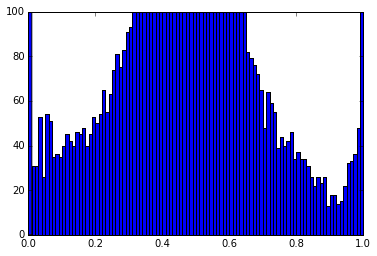

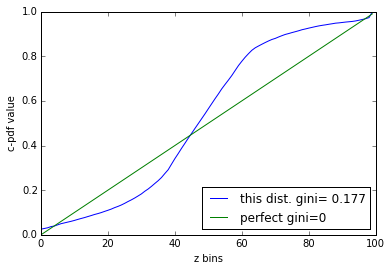

In [14]:
t1 = time.time()
Z_SPEC = dataFrame['Z_SPEC']

nomalisepdfs = pval.normalisepdfs(pdfs, zbins)
y_axis_vals = pval.cumaltive_to_point(nomalisepdfs, zbins, Z_SPEC)

#what do these look like?
#now let's make a histogram of this distribution
N=100
_ = plt.hist(y_axis_vals,bins=N)
plt.ylim(0,100)


#finally, let's measure how far away this is from a flat distribution; with gini = 0.0
gini_val = pval.gini(np.histogram(y_axis_vals, bins=N)[0] * 1.0)
print gini_val
print "this is quite flat! let's check it out"
cum = np.cumsum(np.histogram(y_axis_vals, bins=N)[0])
cum = cum / float(cum[-1])
f = plt.figure()
plt.plot(np.arange(len(cum)), cum, label= 'this dist. gini= %0.3f' % gini_val)
plt.plot(np.arange(len(cum)), np.arange(len(cum))*1.0/len(cum), label='perfect gini=0')
plt.legend(loc=4)
plt.xlabel('z bins')
plt.ylabel('c-pdf value')
print "\n All computations (including plots) took %0.4f secs for %0.1d galaxies" % (time.time() - t1, len(pdfs))

<h3>Boot strap error on these stats</h3>
<p>We can again calculate a boot strap error, using a wrapper written in bh_photo_z_validation.py called <code>bootstrap_mean_error_pdf_point()</code>. You are welcome to write your own, and call is as before (yourFileName.yourFunctionName). Let's first get hold of the weights, and then run the internal functions. These calculations are a little slow ~30secs on my computer (for 10k galaxies) </p>

In [15]:
t1 = time.time()
weights = dataFrame['WEIGHT'] #also accesable through pdfTestConfig['individual']['weights']
meanErr = pval.bootstrap_mean_error_pdf_point(nomalisepdfs, zbins, Z_SPEC, weights, pval.Bordoloi_pdf_test)
print "mean and error on ", len(dataFrame), " pdfs with 200 BootStrap resamples", meanErr
print "\n All computations took %0.4f secs for %0.1d galaxies" % (time.time() - t1, len(pdfs))

mean and error on  10000  pdfs with 200 BootStrap resamples {'sigma': 0.0028718369225984959, 'mean': 0.17662269999999999}

 All computations took 33.5745 secs for 10000 galaxies


<h3>Compare dn/dz distributions</h3>
<p>We also compare dndz distributions, using either built in metrics, or as before, you can write your own. These metrics take the un-normalised distributions (and should normalise if required). Let's start with an exmaple:</p>

In [16]:
#which tests do we want to perform?
print 
test = testConfig['pdf']['stacks']
print "\nThis means that we will use " + test['truths'] + " as the truth column, and form dNdz bins like"
print test['truth_bins'][0][test['truths']]



This means that we will use Z_SPEC as the truth column, and form dNdz bins like
numpy.arange(5)*0.33


<p>Let's explore this first test, bh_photo_z_validation.npoisson</p> <p>Let's first make the dNdz of the "truth" distribution, we will be comparing to. Be careful! If this have bins with 0 in them, many statistical routines will fail!</p>

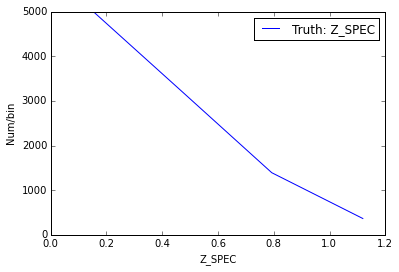

In [17]:
from scipy import stats
truth_col = test['truth_bins'][0].keys()[0]

truth_bins_edges = eval(test['truth_bins'][0][truth_col])
truths = np.array(dataFrame[truth_col])
truth_dist = np.histogram(truths, bins=truth_bins_edges)[0]*1.0

#let's be careful about the bin centers: they are not! the center of the bin, but the average value in the bin
truth_bins_centers = stats.binned_statistic(truths, truths, bins=truth_bins_edges, statistic=np.mean).statistic

plt.plot(truth_bins_centers, truth_dist, label='Truth: ' + truth_col)
plt.legend(loc=1)
plt.ylabel('Num/bin')
plt.xlabel(truth_col)

<p>Now let's do the same for the pdfs, and perfrom the tests. All of these messy details are hidden from the user inby calling the photoz_metric.py script.</p>

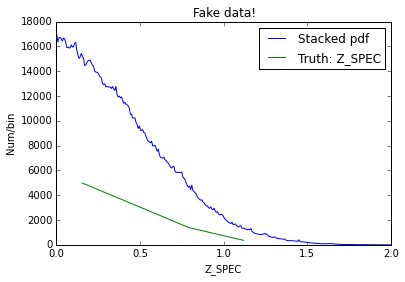

In [18]:
#let's get pdf_ column headings, and extract the value of the bin edge:
zcols = [c for c in dataFrame.keys() if 'pdf_' in c]
pdf_z_edge = np.array([float(c.split('f_')[-1]) for c in zcols])
pdf_z_center = pdf_z_edge + np.append((pdf_z_edge[1:] - pdf_z_edge[0: -1]) / 2.0, (pdf_z_edge[-1] - pdf_z_edge[-2]) / 2.0)

#the pdf's are store here for each galaxy
pdf = np.array(dataFrame[zcols])

#and we can stack them using this code
stacked_pdf = pval.stackpdfs(pdf)

#let's plot the result!

plt.plot(pdf_z_center, stacked_pdf, label='Stacked pdf')
plt.plot(truth_bins_centers, truth_dist, label='Truth: ' + truth_col)
plt.legend(loc=1)
plt.ylabel('Num/bin')
plt.xlabel(truth_col)
plt.title('Fake data!')

#beware that we may have truth's at a different binning resolution than the pdfs. We need to combine the pdfs to cope with this


<p>Now we are ready to perform the comparison test! Just like before, we can *also* make the test by binning in a choice of features. See the yaml file for more details.</p>

In [19]:
stckd_pdfs_at_trth_cntrs = pval.interpolate_dist(stacked_pdf, pdf_z_center, truth_bins_centers)

print 'Npoisson value', pval.npoisson(truth_dist, stckd_pdfs_at_trth_cntrs)

Npoisson value 106.977342914


And we're done!

<h2>Results files</h2>
<p>We write the results of the validation script (recall it's called like) </p>

<code>%>photoz_metrics.py data/PointPredictions1.fits </code>

<p>Using a results File Prefix which you may have set in the testConfiguration Yaml file.

<p>Into a lovely YaML file for human easy reading, and also as a pickle file. This means we can pass the outputs into the plotting tool. An example of that is (or will be) in this notebook directory soon! </p>

<h3>Output</h3>

<p>Example of the output is below:</p>


In [20]:
#in this example we don't have resultsFilePrefix. 
#print "test prefix", testConfig['resultsFilePrefix']

In [21]:
#output file name:
pointResults = 'point_.p'
pointResults = 'point_.yaml'
pdfResults = 'pdf_.p'
pdfResults = 'pdf_.yaml'

<p>The results are formatted to look like this: (in e.g. points_.yaml), and can be read using <code>python pickle</code> or <code>yaml.load()</code> as before </p>

<code>
tests/data/validPointPrediction.fits:
  0:
    Z_MC:
      bh_photo_z_validation.sigma_68:
        delta_z:
          VALUE: 0.7035013244853514
          bins:
            Z_MC:
              BIN_CENTERS:
              - 0.2593094256649402
              - 0.7587431412716394
              - 1.4909100996939546
              BIN_CENTERS_MEAN_BS:
              - 0.2617489006521707
              - 0.759508863364966
              - 1.4927365449936938
              BIN_CENTERS_SIGMA_BS:
              - 0.008674035664842377
              - 0.009549516216673822
              - 0.013034528528585611
              MEAN_BS:
              - 0.334349762217648
              - 0.34009724283466963
              - 0.40911843435271694
              SIGMA_BS:
              - 0.019772862096479635
              - 0.02627186735715245
              - 0.016312035676113744
              VALUE:
              - 0.3283407192008526
              - 0.32228114188030743
              - 0.41986501332174475
        diff_1pz:
          VALUE: 0.2840504374875773
          bins:
            Z_MC:
              BIN_CENTERS:
              - 0.2593094256649402
              - 0.7587431412716394
              - 1.4909100996939546
              BIN_CENTERS_MEAN_BS:
              - 0.26151256908410203
              - 0.7593840546088471
              - 1.492391911786944
              BIN_CENTERS_SIGMA_BS:
              - 0.00886473342482512
              - 0.009578223372819055
              - 0.013132219172208937
              MEAN_BS:
              - 0.08723858288599118
              - 0.11446066934486837
              - 0.17185082125162893
              SIGMA_BS:
              - 0.0060519403768464885
              - 0.008752563717080358
              - 0.006043700892506574
              VALUE:
              - 0.08452927318731282
              - 0.10696974619042877
              - 0.17107178338923312

</code>

In [22]:
for_WL = pval.weighted_nz_distributions(dataFrame, binning=zbins, weights=None, tomo_bins=[0,0.2,0.5], z_phot= dataFrame.Z_SPEC.values , n_resample=50)

In [23]:
df_mean = pval.mean(dataFrame, binning=zbins, weights=None, metric='mode', tomo_bins=[0,0.2,0.5, 1.0, 2.0], z_phot= dataFrame.Z_SPEC.values , n_resample=50)

5


In [24]:
df_mean

,mean_z_bin,n_obj,mean_spec,err_mean_spec,mean_phot,err_mean_phot,w_mean_spec,w_err_mean_spec,w_mean_phot,w_err_mean_phot
"z [0, 0.2]",0.10,3199,0.096915,0.000873,0.066057,0.001166,0.096904,0.000920,0.065935,0.001250
"z [0.2, 0.5]",0.35,3724,0.340223,0.001349,0.333057,0.001517,0.340350,0.001594,0.333250,0.001848
"z [0.5, 1.0]",0.75,2663,0.692739,0.002848,0.689309,0.002873,0.692516,0.002497,0.689078,0.002661
"z [1.0, 2.0]",1.50,414,1.181392,0.006861,1.179145,0.007293,1.181431,0.007222,1.179006,0.007637


In [1]:
data = pd.read_csv('/Users/Christopher_old/Desktop/RF_S82_point_estimates.csv')

In [2]:
data['MEAN_Z'] = data.Z_PHOT

In [3]:
data.to_csv('/Users/Christopher_old/Desktop/RF_S82_point_estimates.csv',index=False)